# LSGANs - Least Squares Generative Adversarial Networks

Brief introduction to Least Squares Generative Adversarial Networks or LSGANs. This notebook is organized as follows:

1. **Research Paper**
* **Background**
* **Definition**
* **Training WGAN with MNIST dataset, Keras and TensorFlow**


## 1. Research Paper

* [Least Squares Generative Adversarial Networks](https://arxiv.org/pdf/1611.04076.pdf)

## 2. Background

**Generative adversarial nets** consists of two models: a generative model $G$ that captures the data distribution, and a discriminative model $D$ that estimates the probability that a sample came from the training data rather than $G$.

The generator distribution $p_g$ over data data $x$, the generator builds a mapping function from a prior noise distribution $p_z(z)$ to data space as $G(z;\theta_g)$.

The discriminator, $D(x;\theta_d)$, outputs a single scalar representing the probability that $x$ came form training data rather than $p_g$.

The **value function** $V(G,D)$:

$$ \underset{G}{min} \: \underset{D}{max} \; V_{GAN}(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$

## 3. Definition

Least Squares Generative Adversarial Networks (LSGANs) adopt the **least squares loss function** for the discriminator. 

The least squares loss function is able to move the fake samples toward the decision boundary, because the least squares loss function penalizes samples that lie in a long way on the correct side of the decision boundary. 

Another benefit of LSGANs is the improved stability of learning process.

### Network Design

<img src="../../img/network_design_gan.png" width="600"> 


### Cost Funcion

$$ 
\begin{aligned}
    \underset{D}{min} \; V_{LSGAN}(D,G) =& \frac{1}{2} \mathbb{E}_{x\sim p_{data}(x)}[(D(x)-b)^2] + \frac{1}{2} \mathbb{E}_{z\sim p_{z}(z)}[(D(G(z))-a)^2] \\
    \underset{G}{min} \; V_{LSGAN}(D,G) =& \frac{1}{2} \mathbb{E}_{z\sim p_{z}(z)}[(D(G(z))-c)^2]
\end{aligned}
$$

where $a$ and $b$ are the labels for fake data and real data, respectively, and $c$ denotes the value that G wants D to believe for fake data.

## 4. Training LSGANs with MNIST dataset, Keras and TensorFlow

* Data
    * Rescale the MNIST images to be between -1 and 1.

* Generator
    * **Simple fully connected neural network**, **LeakyReLU activation** and **BatchNormalization**.
    * The input to the generator is called 'latent sample' (100 values) which is a series of randomly generated numbers, and produces 784 (=28x28) data points which represent a digit image. We use the **normal distribution**.
        The last activation is **tanh**.

* Discriminator
    * **Simple fully connected neural network** and **LeakyReLU activation**.
    * The last activation is **sigmoid**.

*  Loss
    * loss='mse'

* Optimizer
    * Adam(lr=0.0002, beta_1=0.5)

* batch_size = 64
* epochs = 100


### 1. Load data

#### Load libraries

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.layers import Input, Flatten, Reshape
from keras.optimizers import Adam
from keras import initializers
from keras import backend as K

Using TensorFlow backend.


#### Getting the data

In [3]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#### Explore visual data

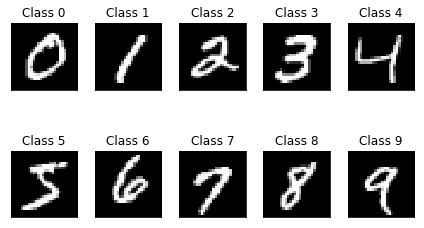

In [4]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

#### Reshaping and normalizing the inputs

In [5]:
print('X_train.shape', X_train.shape)

# reshaping the inputs
X_train = X_train.reshape(60000, 28*28)
# normalizing the inputs (-1, 1)
X_train = (X_train.astype('float32') / 255 - 0.5) * 2

print('X_train reshape:', X_train.shape)

X_train.shape (60000, 28, 28)
X_train reshape: (60000, 784)


### 2. Define model

#### Generator


In [6]:
# latent space dimension
latent_dim = 100

# imagem dimension 28x28x1
img_dim = 784

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# Input layer and hidden layer 1
generator.add(Dense(128, input_shape=(latent_dim,), kernel_initializer=init))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Hidden layer 2
generator.add(Dense(256))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Hidden layer 3
generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))

# Output layer 
generator.add(Dense(img_dim, activation='tanh'))

#### Generator model visualization

In [7]:
# prints a summary representation of your model
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
__________

#### Discriminator

In [8]:
# Discriminator network
discriminator = Sequential()

# Hidden layer 1
discriminator.add(Dense(128, input_shape=(img_dim,), kernel_initializer=init))
discriminator.add(LeakyReLU(alpha=0.2))

# Hidden layer 2
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=0.2))

# Hidden layer 3
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(alpha=0.2))

# Output layer
discriminator.add(Dense(1))

#### Discriminator model visualization

In [9]:
# prints a summary representation of your model
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total para

### 3. Compile model

#### Compile discriminator

In [10]:
# Optimizer
optimizer = Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(optimizer=optimizer, loss='mse', metrics=['binary_accuracy'])

#### Combined network

In [11]:
discriminator.trainable = False

z = Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = Model(inputs=z, outputs=decision)

# Optimize w.r.t. MSE loss instead of crossentropy
d_g.compile(optimizer=optimizer, loss='mse', metrics=['binary_accuracy'])

In [12]:
# prints a summary representation of your model
d_g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               583312    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 265601    
Total params: 848,913
Trainable params: 581,520
Non-trainable params: 267,393
_________________________________________________________________


### 4. Fit model


epoch = 1/100, d_loss=0.159, g_loss=0.474                                                                                                                        


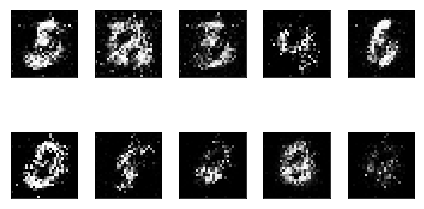

epoch = 2/100, d_loss=0.202, g_loss=0.447                                                                                                                        
epoch = 3/100, d_loss=0.220, g_loss=0.415                                                                                                                                                                                                                            
epoch = 4/100, d_loss=0.181, g_loss=0.366                                                                                                                        
epoch = 5/100, d_loss=0.235, g_loss=0.328                                                                                                                        
epoch = 6/100, d_loss=0.204, g_loss=0.370                                                                                                                        
epoch = 7/100, d_loss=0.188, g_loss=0.363                                                 

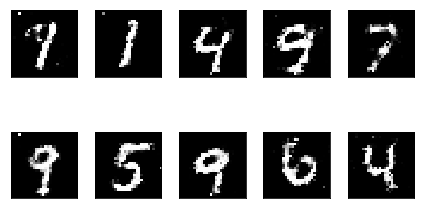

epoch = 12/100, d_loss=0.206, g_loss=0.398                                                                                                                        
epoch = 13/100, d_loss=0.193, g_loss=0.403                                                                                                                        
epoch = 14/100, d_loss=0.183, g_loss=0.465                                                                                                                        
epoch = 15/100, d_loss=0.169, g_loss=0.473                                                                                                                        
epoch = 16/100, d_loss=0.142, g_loss=0.396                                                                                                                        
epoch = 17/100, d_loss=0.165, g_loss=0.394                                                                                                                        
epoch = 18/100, d_loss

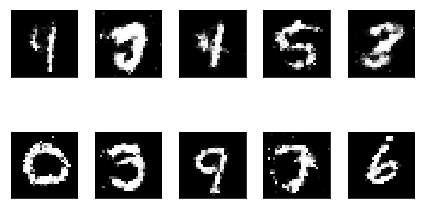

epoch = 22/100, d_loss=0.146, g_loss=0.461                                                                                                                        
epoch = 23/100, d_loss=0.186, g_loss=0.427                                                                                                                        
epoch = 24/100, d_loss=0.171, g_loss=0.425                                                                                                                        
epoch = 25/100, d_loss=0.185, g_loss=0.371                                                                                                                        
epoch = 26/100, d_loss=0.177, g_loss=0.383                                                                                                                        
epoch = 27/100, d_loss=0.171, g_loss=0.391                                                                                                                        
epoch = 28/100, d_loss

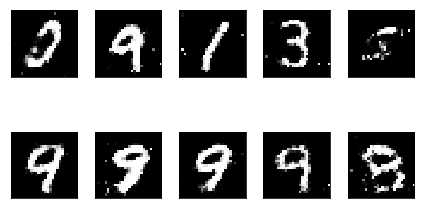

epoch = 32/100, d_loss=0.168, g_loss=0.456                                                                                                                        
epoch = 33/100, d_loss=0.136, g_loss=0.460                                                                                                                        
epoch = 34/100, d_loss=0.183, g_loss=0.485                                                                                                                        
epoch = 35/100, d_loss=0.176, g_loss=0.532                                                                                                                        
epoch = 36/100, d_loss=0.194, g_loss=0.488                                                                                                                        
epoch = 37/100, d_loss=0.213, g_loss=0.411                                                                                                                        
epoch = 38/100, d_loss

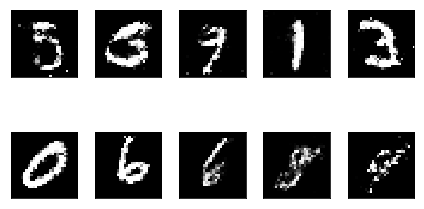

epoch = 42/100, d_loss=0.186, g_loss=0.408                                                                                                                        
epoch = 43/100, d_loss=0.197, g_loss=0.524                                                                                                                        
epoch = 44/100, d_loss=0.207, g_loss=0.419                                                                                                                        
epoch = 45/100, d_loss=0.180, g_loss=0.420                                                                                                                        
epoch = 46/100, d_loss=0.185, g_loss=0.434                                                                                                                        
epoch = 47/100, d_loss=0.172, g_loss=0.470                                                                                                                        
epoch = 48/100, d_loss

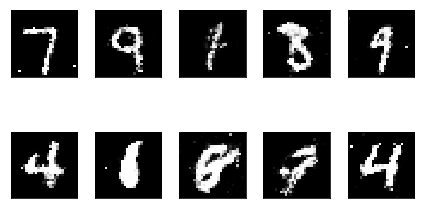

epoch = 52/100, d_loss=0.164, g_loss=0.412                                                                                                                        
epoch = 53/100, d_loss=0.193, g_loss=0.429                                                                                                                        
epoch = 54/100, d_loss=0.178, g_loss=0.438                                                                                                                        
epoch = 55/100, d_loss=0.177, g_loss=0.376                                                                                                                        
epoch = 56/100, d_loss=0.205, g_loss=0.561                                                                                                                        
epoch = 57/100, d_loss=0.166, g_loss=0.429                                                                                                                        
epoch = 58/100, d_loss

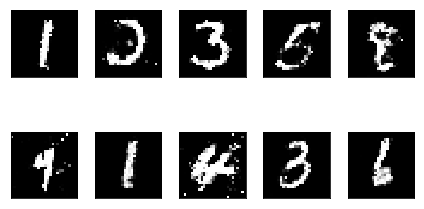

epoch = 62/100, d_loss=0.158, g_loss=0.418                                                                                                                        
epoch = 63/100, d_loss=0.138, g_loss=0.420                                                                                                                        
epoch = 64/100, d_loss=0.171, g_loss=0.390                                                                                                                        
epoch = 65/100, d_loss=0.189, g_loss=0.530                                                                                                                        
epoch = 66/100, d_loss=0.140, g_loss=0.561                                                                                                                        
epoch = 67/100, d_loss=0.199, g_loss=0.611                                                                                                                        
epoch = 68/100, d_loss

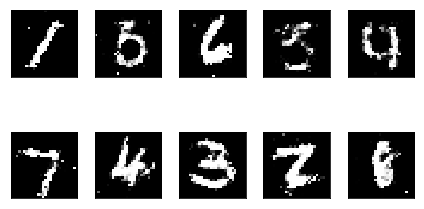

epoch = 72/100, d_loss=0.214, g_loss=0.436                                                                                                                        
epoch = 73/100, d_loss=0.144, g_loss=0.628                                                                                                                        
epoch = 74/100, d_loss=0.210, g_loss=0.526                                                                                                                        
epoch = 75/100, d_loss=0.141, g_loss=0.458                                                                                                                        
epoch = 76/100, d_loss=0.168, g_loss=0.517                                                                                                                        
epoch = 77/100, d_loss=0.153, g_loss=0.479                                                                                                                        
epoch = 78/100, d_loss

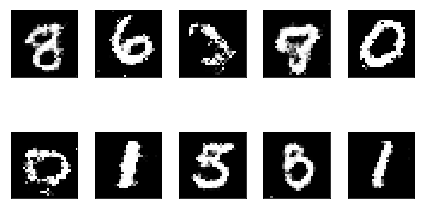

epoch = 82/100, d_loss=0.177, g_loss=0.541                                                                                                                        
epoch = 83/100, d_loss=0.124, g_loss=0.565                                                                                                                        
epoch = 84/100, d_loss=0.157, g_loss=0.525                                                                                                                        
epoch = 85/100, d_loss=0.122, g_loss=0.537                                                                                                                        
epoch = 86/100, d_loss=0.118, g_loss=0.526                                                                                                                        
epoch = 87/100, d_loss=0.147, g_loss=0.556                                                                                                                        
epoch = 88/100, d_loss

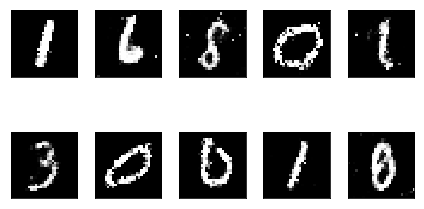

epoch = 92/100, d_loss=0.125, g_loss=0.546                                                                                                                        
epoch = 93/100, d_loss=0.156, g_loss=0.571                                                                                                                        
epoch = 94/100, d_loss=0.168, g_loss=0.559                                                                                                                        
epoch = 95/100, d_loss=0.200, g_loss=0.558                                                                                                                        
epoch = 96/100, d_loss=0.142, g_loss=0.602                                                                                                                        
epoch = 97/100, d_loss=0.152, g_loss=0.557                                                                                                                        
epoch = 98/100, d_loss

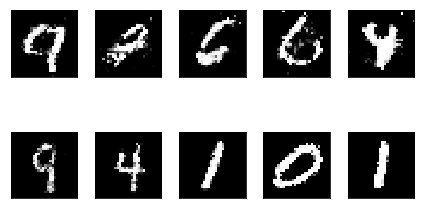

In [13]:
epochs = 100
batch_size = 32

a = np.zeros(shape=(batch_size//2, 1))
b = np.ones(shape=(batch_size//2, 1))
c = np.ones(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_real = X_train[i*batch_size//2:(i+1)*batch_size//2]
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size//2, latent_dim))
        X_fake = generator.predict_on_batch(z)
        
        # Discriminator loss
        d_loss_batch = discriminator.train_on_batch(
            x=np.concatenate((X_fake, X_real), axis=0),
            y=np.concatenate((a, b), axis=0)
        )
        
        # Train Generator weights
        discriminator.trainable = False
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        d_g_loss_batch = d_g.train_on_batch(x = z, y = c)
   
        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch[0], d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch[0])
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

### 5. Evaluate model

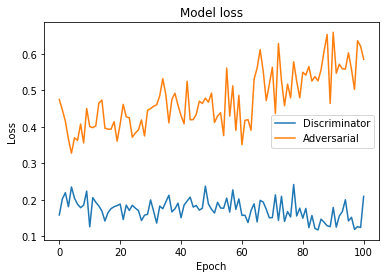

In [14]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()